In [1]:
# Import neccesary library 
import pandas as pd
import geopandas as gpd
from fuzzywuzzy import process
import glob 
import os 
import re
import matplotlib.patches as mpatches

### Loading and Processing the Rainfall Data For 2023 

In [2]:
# Define the directory where your files are located
directory = "/home/kda115/rainfall_2023"


# Use glob to find all csv files in the directory
all_files = glob.glob(os.path.join(directory, "*.csv"))

# Initialize an empty list to hold DataFrames
dfs = []

# Loop through each file and read it into a DataFrame
for filename in all_files:
    df = pd.read_csv(filename)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
rainfall_2023 = pd.concat(dfs, ignore_index=True)

In [3]:
# Replace "United States" with "United States of America" in the Country_Name column
rainfall_2023['Country_Name'] = rainfall_2023['Country_Name'].replace('United States', 'United States of America')

# Show the result 
rainfall_2023.head(5)

,Country_Code,Total_Rainfall_Country,Station_Count,Average_Rainfall,Country_Name,Average_Rainfall_mm
0,BR,193200,17,11364.705882,Brazil,1136.470588
1,CY,2586,1,2586.000000,Cyprus,258.600000
2,IS,14565,5,2913.000000,Israel,291.300000
3,TH,709914,45,15775.866667,Thailand,1577.586667
4,TS,12043,5,2408.600000,Tunisia,240.860000


In [4]:
# Country the number of country in the rainfall 2023 dataset 
rainfall_2023['Country_Name'].count()

182

In [5]:
# Write the function to remove all bracket 
def remove_brackets(text):
    # Use regex to remove text inside any type of brackets
    return re.sub(r'\s*[\[\(\{].*?[\]\)\}]', '', text).strip()

# Apply the function to the Country_Name column
rainfall_2023['Country_Name'] = rainfall_2023['Country_Name'].apply(remove_brackets)

In [6]:
# Check whether the bracket are removed
teritories_remove_check = rainfall_2023[rainfall_2023['Country_Name'] == 'Cook Islands']

teritories_remove_check

,Country_Code,Total_Rainfall_Country,Station_Count,Average_Rainfall,Country_Name,Average_Rainfall_mm
154,CW,9519,1,9519.0,Cook Islands,951.9


In [7]:
# Load the world dataset from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/tmp/ipykernel_2225413/3184012259.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


### Use the Regular Expression to find and match rainfall country name pattern with country name in world dataset 

In [8]:
def match_country_by_first_three_chars(rainfall_country, world_countries):
    # Convert the first 4 characters of the input country to lowercase
    rainfall_prefix = rainfall_country[:4].lower()
    
    # Loop through the list of world countries
    for world_country in world_countries:
        # Convert the first 4 characters of the world country to lowercase
        world_prefix = world_country[:4].lower()
        
        # Check if the prefixes match
        if rainfall_prefix == world_prefix:
            return world_country
    
    # Return None if no match is found
    return None

In [9]:
# Apply the function to the 'Country_Name' column in rainfall_2023
world_countries = world['name'].unique()
rainfall_2023['Country_Name_REGEXP'] = rainfall_2023['Country_Name'].apply(lambda x: match_country_by_first_three_chars(x, world_countries))

# Display the DataFrame with the new matched country names
rainfall_2023

,Country_Code,Total_Rainfall_Country,Station_Count,Average_Rainfall,Country_Name,Average_Rainfall_mm,Country_Name_REGEXP
0,BR,193200,17,11364.705882,Brazil,1136.470588,Brazil
1,CY,2586,1,2586.000000,Cyprus,258.600000,Cyprus
2,IS,14565,5,2913.000000,Israel,291.300000,Israel
3,TH,709914,45,15775.866667,Thailand,1577.586667,Thailand
4,TS,12043,5,2408.600000,Tunisia,240.860000,Tunisia
...,...,...,...,...,...,...,...
177,GV,91065,8,11383.125000,Guinea,1138.312500,Guinea
178,JN,5713,1,5713.000000,Jan Mayen,571.300000,None
179,MU,22331,27,827.074074,Oman,82.707407,Oman
180,RI,22037,3,7345.666667,Serbia,734.566667,Serbia


In [10]:
# Filter and display rows where no match was found
rainfall_2023['Country_Name_REGEXP'].isna().sum()

36

### Use the FUZZY WUZZY package to check the similarity pattern between rainfall_2023 country name and world dataset 

In [11]:
# Define Fuzzy Matching Function
def fuzzy_match_country(rainfall_country, world_countries, threshold=90):
    # Use fuzzywuzzy's process.extractOne to find the best match
    match, score = process.extractOne(rainfall_country, world_countries)
    
    # Check if the score meets the threshold
    if score >= threshold:
        return match
    else:
        return None

In [12]:
# Get unique country names from the world dataset
world_countries = world['name'].unique()

# Apply the fuzzy matching function to the 'Country_Name' column in rainfall_2023
rainfall_2023['Country_Name_FUZZY'] = rainfall_2023['Country_Name'].apply(
    lambda x: fuzzy_match_country(x, world_countries))

# Print out the result 
rainfall_2023

,Country_Code,Total_Rainfall_Country,Station_Count,Average_Rainfall,Country_Name,Average_Rainfall_mm,Country_Name_REGEXP,Country_Name_FUZZY
0,BR,193200,17,11364.705882,Brazil,1136.470588,Brazil,Brazil
1,CY,2586,1,2586.000000,Cyprus,258.600000,Cyprus,Cyprus
2,IS,14565,5,2913.000000,Israel,291.300000,Israel,Israel
3,TH,709914,45,15775.866667,Thailand,1577.586667,Thailand,Thailand
4,TS,12043,5,2408.600000,Tunisia,240.860000,Tunisia,Tunisia
...,...,...,...,...,...,...,...,...
177,GV,91065,8,11383.125000,Guinea,1138.312500,Guinea,Guinea
178,JN,5713,1,5713.000000,Jan Mayen,571.300000,None,None
179,MU,22331,27,827.074074,Oman,82.707407,Oman,Oman
180,RI,22037,3,7345.666667,Serbia,734.566667,Serbia,Serbia


### Combined REG_EXP & Fuzzy to get the consistent country name 

In [13]:
def combine_country_names(row):
    if pd.notna(row['Country_Name_REGEXP']) and pd.isna(row['Country_Name_FUZZY']):
        return row['Country_Name_REGEXP']
    elif pd.isna(row['Country_Name_REGEXP']) and pd.notna(row['Country_Name_FUZZY']):
        return row['Country_Name_FUZZY']
    elif pd.notna(row['Country_Name_REGEXP']) and pd.notna(row['Country_Name_FUZZY']):
        if row['Country_Name_REGEXP'] == row['Country_Name_FUZZY']:
            return row['Country_Name_FUZZY']
        else:
            return f"{row['Country_Name_FUZZY']}"
    else:
        return None

# Apply the function to create the new column
rainfall_2023['Combined_Country_Name'] = rainfall_2023.apply(combine_country_names, axis=1)

# Display the DataFrame to check the new column
rainfall_2023

,Country_Code,Total_Rainfall_Country,Station_Count,Average_Rainfall,Country_Name,Average_Rainfall_mm,Country_Name_REGEXP,Country_Name_FUZZY,Combined_Country_Name
0,BR,193200,17,11364.705882,Brazil,1136.470588,Brazil,Brazil,Brazil
1,CY,2586,1,2586.000000,Cyprus,258.600000,Cyprus,Cyprus,Cyprus
2,IS,14565,5,2913.000000,Israel,291.300000,Israel,Israel,Israel
3,TH,709914,45,15775.866667,Thailand,1577.586667,Thailand,Thailand,Thailand
4,TS,12043,5,2408.600000,Tunisia,240.860000,Tunisia,Tunisia,Tunisia
...,...,...,...,...,...,...,...,...,...
177,GV,91065,8,11383.125000,Guinea,1138.312500,Guinea,Guinea,Guinea
178,JN,5713,1,5713.000000,Jan Mayen,571.300000,None,None,None
179,MU,22331,27,827.074074,Oman,82.707407,Oman,Oman,Oman
180,RI,22037,3,7345.666667,Serbia,734.566667,Serbia,Serbia,Serbia


### Validate the matching after combined 

In [14]:
# Count the number of unmatch countries
rainfall_2023['Combined_Country_Name'].isna().sum()

31

In [15]:
# Filter the DataFrame where 'Country_Name' is not equal to 'Combined_Country_Name'
unequal_names = rainfall_2023[rainfall_2023['Country_Name'] != rainfall_2023['Combined_Country_Name']]

# Display the filtered DataFrame
unequal_names

,Country_Code,Total_Rainfall_Country,Station_Count,Average_Rainfall,Country_Name,Average_Rainfall_mm,Country_Name_REGEXP,Country_Name_FUZZY,Combined_Country_Name
6,EK,20499,2,10249.500000,Equatorial Guinea,1024.950000,None,Guinea,Guinea
7,FG,35343,1,35343.000000,French Guiana,3534.300000,None,None,None
26,CJ,11734,1,11734.000000,Cayman Islands,1173.400000,None,None,None
27,GQ,385786,15,25719.066667,Guam,2571.906667,None,None,None
34,AQ,144969,4,36242.250000,American Samoa,3624.225000,None,None,None
35,BF,522883,45,11619.622222,"Bahamas, The",1161.962222,Bahamas,Bahamas,Bahamas
42,FK,4225,1,4225.000000,Falkland Islands,422.500000,Falkland Is.,None,Falkland Is.
49,TV,24846,2,12423.000000,Tuvalu,1242.300000,None,None,None
51,BP,80683,3,26894.333333,Solomon Islands,2689.433333,Solomon Is.,Solomon Is.,Solomon Is.
53,MF,7925,1,7925.000000,Mayotte,792.500000,None,None,None


#### Since Northern Mariana Islands is defined as North Korea in Combined Country columns, we manually adjust it to None 

In [16]:
# Set 'Combined_Country_Name' to None where 'Country_Name' is 'Northern Mariana Islands'
rainfall_2023.loc[rainfall_2023['Country_Name'] == 'Northern Mariana Islands', 'Combined_Country_Name'] = None

In [17]:
# Checking the result 
check = rainfall_2023[rainfall_2023['Country_Name'] == 'Congo']
check

,Country_Code,Total_Rainfall_Country,Station_Count,Average_Rainfall,Country_Name,Average_Rainfall_mm,Country_Name_REGEXP,Country_Name_FUZZY,Combined_Country_Name
46,CF,111647,15,7443.133333,Congo,744.313333,Congo,Congo,Congo
47,CG,9404,6,1567.333333,Congo,156.733333,Congo,Congo,Congo


### Join the Rainfall_2023 dataset to the World dataset using "Combined_Country_Name"

In [18]:
# Merge matched countries with the world dataset to visualize the results
rainfall_2023 = rainfall_2023.dropna(subset=['Combined_Country_Name'])

# Merge the rainfall_2023 DataFrame with the world GeoDataFrame
merged_df = world.merge(rainfall_2023, left_on='name', right_on='Combined_Country_Name')

# Display the merged DataFrame to verify the merge
merged_df.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Country_Code,Total_Rainfall_Country,Station_Count,Average_Rainfall,Country_Name,Average_Rainfall_mm,Country_Name_REGEXP,Country_Name_FUZZY,Combined_Country_Name
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJ,86237,5,17247.400000,Fiji,1724.740000,Fiji,Fiji,Fiji
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZ,85220,7,12174.285714,Tanzania,1217.428571,Tanzania,Tanzania,Tanzania
2,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CA,11188297,1715,6523.788338,Canada,652.378834,Canada,Canada,Canada
3,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",US,220891556,30891,7150.676767,United States of America,715.067677,United States of America,United States of America,United States of America
4,18513930.0,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",KZ,20545,16,1284.062500,Kazakhstan,128.406250,Kazakhstan,Kazakhstan,Kazakhstan


In [19]:
# Find the number of duplicate rows in the DataFrame
duplicate_count = merged_df.duplicated().sum()

# Print the count of duplicate rows
duplicate_count

0

In [20]:
# Checking the na values for the combined column
merged_df['Combined_Country_Name'].isna().sum()

0

### Plot the Global Rainfall 2023 

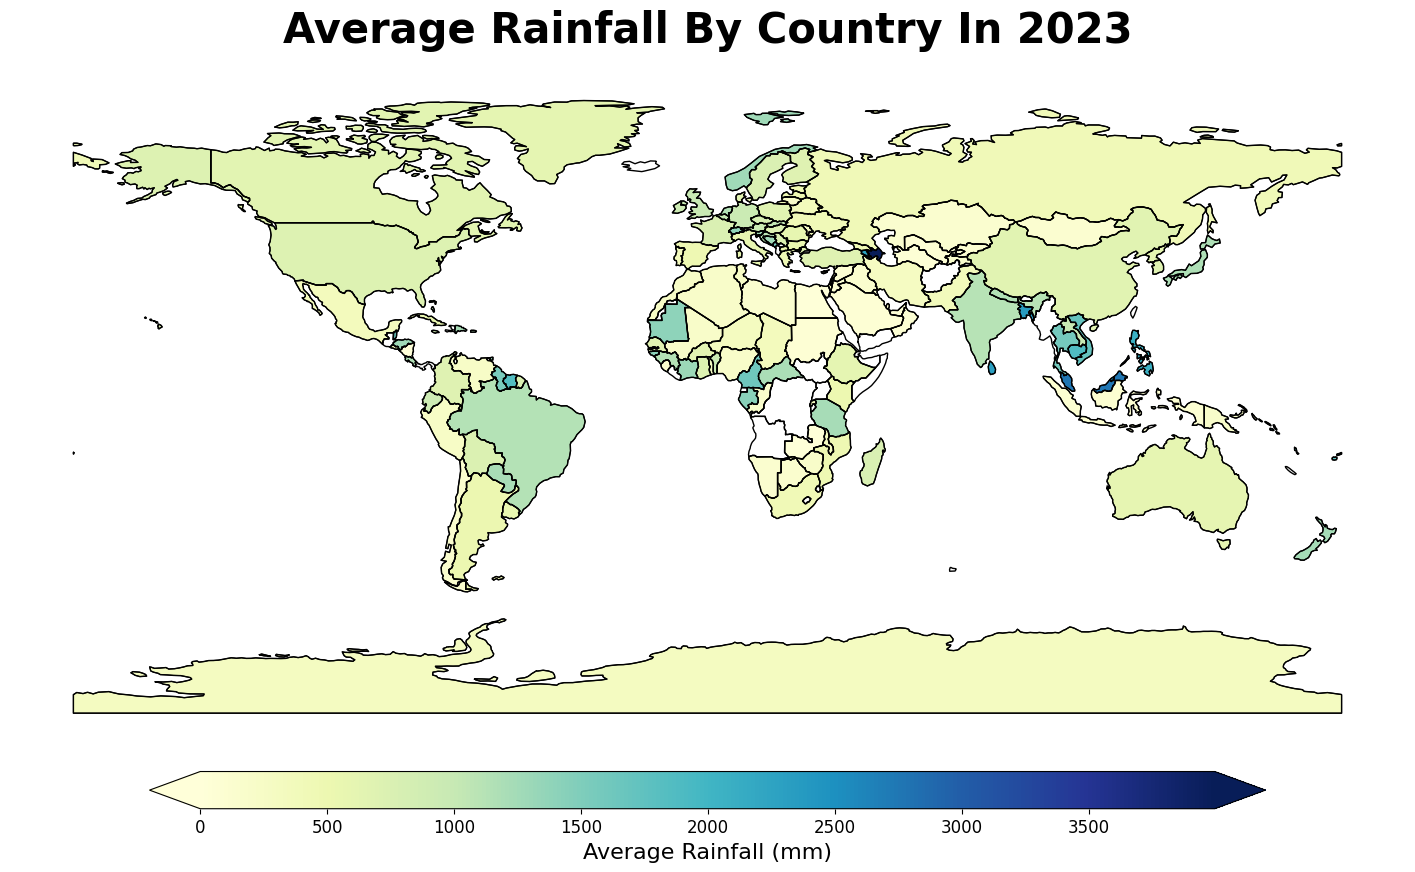

In [33]:
import matplotlib.pyplot as plt

# Plot the world map with average rainfall highlighted
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

# Plot the world boundaries
world.boundary.plot(ax=ax, linewidth=1, edgecolor='black')

# Plot the merged GeoDataFrame with rainfall data
merged_df.plot(
    column='Average_Rainfall_mm',
    ax=ax,
    legend=True,
    cmap='YlGnBu',  # Changed colormap to YlGnBu for better visual distinction
    linewidth=0.8,  # Set boundary line width
    edgecolor='black',  # Set edge color for countries
    legend_kwds={
        'label': "Average Rainfall (mm)",
        'orientation': "horizontal",
        'shrink': 0.8,  # Adjust the size of the legend
        'pad': 0.03,
        'aspect': 30,
        'extend': 'both'
    }
)

# Adjust the font size of the colorbar label and ticks
cbar = ax.get_figure().get_axes()[-1]  # Get the colorbar axis
cbar.set_xlabel('Average Rainfall (mm)', fontsize=16)  # Set the font size for the label
cbar.tick_params(labelsize=12)  # Adjust the font size for the ticks

# Customize the title and labels
plt.title(
    'Average Rainfall By Country In 2023',
    fontsize=30,  # Increase title font size
    pad=20,  # Add padding to the title
    weight='bold'
)

# Remove axis for a cleaner look
ax.set_axis_off()

# Customize the layout to better fit the map and legend
# plt.subplots_adjust(left=0.02, right=0.98, top=0.95, bottom=0.05)

# Save the map to a file
plt.savefig("average_rainfall_map_2023.png", dpi=300, bbox_inches='tight')

# Show the map
plt.show()